<a href="https://colab.research.google.com/github/ansonkwokth/TableTennisPrediction/blob/main/H2H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ansonkwokth/TableTennisPrediction.git
%cd TableTennisPrediction

fatal: destination path 'TableTennisPrediction' already exists and is not an empty directory.
/content/TableTennisPrediction


In [19]:
import pandas as pd
from tabulate import tabulate
from utils import data_loader as dl

import numpy as np
# from model.Elo import Elo
from model.ModifiedElo import ModifiedElo
# from model.ensemble import BaggingRatingSystem

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import copy

import warnings
warnings.filterwarnings('ignore')

# Data

In [34]:
GAME = 'TTStar'
# GAME = 'TTCup'
# GAME = 'SetkaCup'
# GAME = 'SetkaCupWomen'
# GAME = 'LigaPro'


In [35]:
match GAME:
    case 'TTStar':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'TTCup':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'SetkaCup':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'SetkaCupWomen':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'LigaPro':
        years = [2022, 2023, 2024]
    case _:
        raise ValueError("Invalid game selected.")


text_data_game = dl.load_game_data(GAME, years, '../')
text_data = {
    year: text_data_game[year] for year in years
}
df = dl.create_game_dfs(GAME, years, text_data)

Loading ..//TTStar2020.txt
Loading ..//TTStar2021.txt
Loading ..//TTStar2022.txt
Loading ..//TTStar2023.txt
Loading ..//TTStar2024.txt


In [36]:
# Generate ID indices for each pair of rows in the DataFrame
idx_lt = [i for i in range(len(df) // 2) for _ in range(2)]
df['ID'] = idx_lt  # Assign to the 'ID' column

# Reset the DataFrame index to ensure it's sequential
df.reset_index(drop=True, inplace=True)

# Get unique players and store them in player_lt
player_lt = df['Player'].unique()



In [37]:
year_val = years[-2]
year_test = years[-1]


df = df.sort_values(['ID', 'Player'])
df_train = df.loc[pd.DatetimeIndex(df['Date']).year < year_val]
df_val = df.loc[pd.DatetimeIndex(df['Date']).year == year_val]
df_train_val = df.loc[pd.DatetimeIndex(df['Date']).year <= year_val]
df_test = df.loc[pd.DatetimeIndex(df['Date']).year == year_test]


In [38]:
def format_to_array(df: pd.DataFrame) -> np.ndarray:

    # info_col = ['ID', 'Round', 'Datetime', 'Game', 'Date', 'Time']
    info_col = ['Round', 'Datetime', 'Game', 'Date', 'Time']
    col = [item for item in df.columns if item not in info_col]

    df[[c for c in col if "Set" in c]] = df[[c for c in col if "Set" in c]].astype(float)
    X = df[col].values.reshape(-1, 2, len(col))
    return X

In [39]:
X_train = format_to_array(df_train)
X_val = format_to_array(df_val)
X_train_val = format_to_array(df_train_val)
X_test = format_to_array(df_test)

In [40]:
X_all = format_to_array(df)

In [41]:
# modelMElo = ModifiedElo()

# # traing model with only training set
# for _ in range(5):
#     modelMElo.fit(X_train)



# H2H histroy

In [42]:
class SymmetricTable:
    def __init__(self):
        self.data = {}

    def add(self, key1, key2, value):
        """Append value to the list corresponding to the symmetric key."""
        key = tuple(sorted([key1, key2]))
        if key not in self.data:
            self.data[key] = []
        self.data[key].append(value)

    def get(self, key1, key2):
        """Retrieve the list of values for the given symmetric key, defaulting to an empty list."""
        return self.data.get(tuple(sorted([key1, key2])), [])





# Id and the corresponding past h2h history before this match
h2h_rate = {}
table = SymmetricTable()
SETCOL = [i for i in df_train.columns if 'Set' in i]


for id in tqdm(df.ID.unique()):
    df_i = df[df.ID == id]

    player1, player2 = df_i.Player.values
    # all the historical sets
    histo_rate = table.get(player1, player2)
    # the mean of the win rate
    histo_rate_mean = np.mean(histo_rate)
    # add to the dict
    h2h_rate[id] = histo_rate_mean

    df_p_i = df_i.sort_values("Player")
    # the scores of the sets
    scores = df_p_i[SETCOL].values
    winrate_i = (scores[0] / (scores[0] + scores[1]))

    # add the current set results to the history
    for wi in winrate_i:
        if np.isnan(wi): continue
        table.add(player1, player2, wi)


100%|██████████| 17257/17257 [00:19<00:00, 871.89it/s]


# Look at the relation

In [43]:
def evaluate_point(model, dataset, h2h):
    print(f"Evaluate model: {repr(model)}")
    _model = copy.deepcopy(model)
    _model.verbose = False

    history = []
    predictions = []
    h2hs = []
    for idx, matchi in tqdm(enumerate(dataset), desc="Evaluating matches"):
        id = matchi[0, 0]
        matchi = matchi.T
        h2hi = h2h[id]
        player1, player2 = matchi[1]

        found_p1, found_p2, p = _model.predict_point(player1, player2)
        if not (found_p1 and found_p2): continue
        if p == 0.5: continue

        for seti in matchi[2:]:
            if np.isnan(seti[0]) or (seti[0] + seti[1]) == 0: break
            winrate = seti[0] / (seti[0] + seti[1])
            history.append(winrate)
            predictions.append(p)
            h2hs.append(h2hi)


    return np.array(history), np.array(predictions), np.array(h2hs)



In [44]:
hist, pred, h2h = evaluate_point(modelMElo, X_train, h2h_rate)
# hist, pred, h2h = evaluate_point(modelMElo, X_val, h2h_rate)
# hist, pred, h2h = evaluate_point(modelMElo, X_test, h2h_rate)
# hist, pred = evaluate_point(modelMElo, X_val)

Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 9867it [00:00, 148369.14it/s]


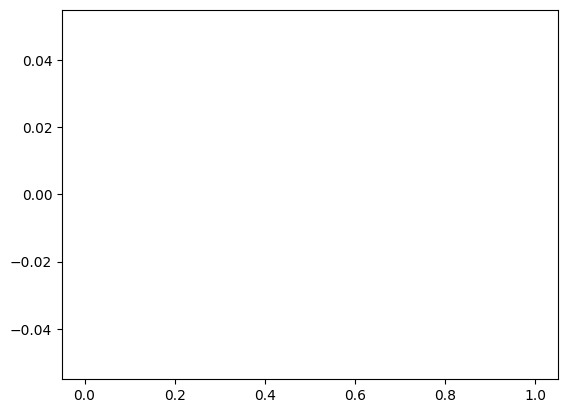

In [45]:
logit_hist = np.log(hist / (1-hist))
logit_pred = np.log(pred / (1-pred))
residul = logit_hist - logit_pred
residul = np.nan_to_num(residul, nan=np.nan, posinf=np.nan, neginf=np.nan)
plt.hist(residul);


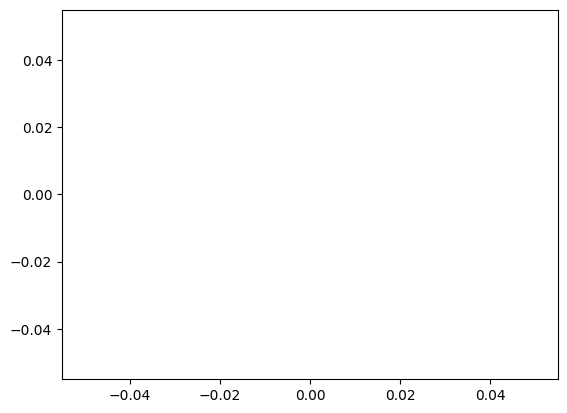

In [46]:
plt.scatter(logit_hist, logit_pred, alpha=0.05)



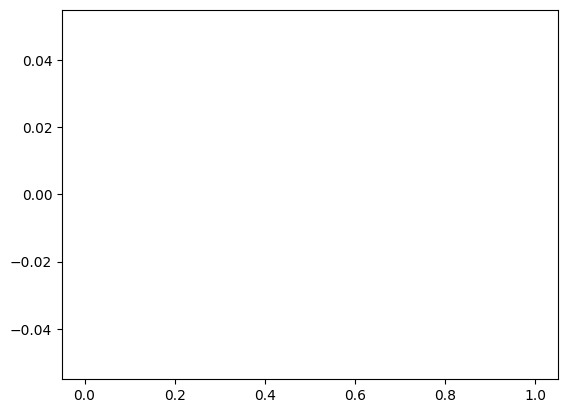

In [47]:
logit_h2h = np.log(h2h / (1-h2h))
logit_h2h = np.nan_to_num(logit_h2h, nan=np.nan, posinf=np.nan, neginf=np.nan)
plt.hist(logit_h2h);


$\hat{y}=\frac{1}{1+\exp{(-x)}}$

$\hat{y}^{(0)}=\frac{1}{1+\exp{(-\Delta S)}}$, $\Delta S\equiv S_1 - S_2$

$\hat{x}^{(1)}=\Delta S + \epsilon_{\rm H}\Delta H$

Fir the residual:

$R\equiv x - \Delta S = \epsilon_{\rm H}\Delta H$.

After fitting the $\hat{\epsilon}_{\rm H}$, then do $\hat{x}^{(1)} = \Delta S + \hat{\epsilon}_{\rm H}\Delta H$

In [48]:

comb = np.array([logit_h2h, residul])

comb = comb[:, ~(abs(comb)<=1e-10).any(axis=0)]
comb = comb[:, ~(abs(comb)>=1e10).any(axis=0)]
comb = comb[:, ~np.any(np.isnan(comb), axis=0)]

Text(0, 0.5, '$R$')

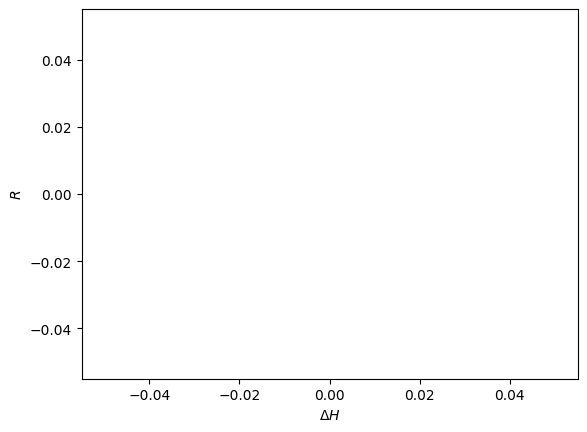

In [49]:
plt.scatter(comb[0], comb[1], alpha=0.05)
plt.xlabel("$\Delta H$")
plt.ylabel("$R$")


In [50]:
import statsmodels.api as sm
x = comb[0]    # Delta H
y = comb[1].reshape(-1, 1)    # Residual
ols = sm.OLS(y, x)
ols_result = ols.fit()
print(ols_result.summary())
eps = ols_result.params[0]
eps

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1, 1), y)
reg.coef_


In [ ]:

plt.scatter(reg.predict(x.reshape(-1, 1)), y, alpha=0.05)
# plt.scatter(x, y, alpha=0.05)

In [ ]:
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2)

# Generate some test data
x, y = comb[0], comb[1]

sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        ax.imshow(img, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.tight_layout()
plt.show()

In [ ]:
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [ ]:
eps = 0.23
y_rot = logit_pred + eps*logit_h2h
comb_rot = np.array([y_rot, logit_hist])

y_rot = eps*logit_h2h
comb_rot = np.array([y_rot, residul])

comb_rot = comb_rot[:, ~(abs(comb_rot)<=1e-10).any(axis=0)]
comb_rot = comb_rot[:, ~(abs(comb_rot)>=1e10).any(axis=0)]
comb_rot = comb_rot[:, ~np.any(np.isnan(comb_rot), axis=0)]


heatmap, xedges, yedges = np.histogram2d(comb_rot[0], comb_rot[1], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [ ]:
y_rot = reg.predict(np.nan_to_num(logit_h2h.reshape(-1, 1), 0)).reshape(1, -1)[0] + logit_pred
pred_1 = 1 / (1 + np.exp(-y_rot))


In [ ]:
plt.scatter(pred_1, pred, alpha=0.05)

In [ ]:
logit_hist = np.log(hist / (1-hist))

residul = logit_hist - y_rot
residul = np.nan_to_num(residul, nan=np.nan, posinf=np.nan, neginf=np.nan)
plt.hist(residul, histtype='step', range=[-3.5, 3.5], bins=10);

logit_hist = np.log(hist / (1-hist))
logit_pred = np.log(pred / (1-pred))
residul = logit_hist - logit_pred
residul = np.nan_to_num(residul, nan=np.nan, posinf=np.nan, neginf=np.nan)
plt.hist(residul, histtype='step', range=[-3.5, 3.5], bins=10);


In [ ]:
sum(np.round(hist) == np.round(pred)) / len(hist)

In [ ]:
sum(np.round(hist) == np.round(y_rot.reshape(1, -1)[0])) / len(hist)

# New Model with H2H

In [51]:
import numpy as np
from tqdm import tqdm
from math import comb



class RatingSystem2:

    def __init__(self, learning_rate=32, binary=False, verbose=False):

        if not isinstance(learning_rate, (float, int)):
            raise TypeError(f"Expected 'learning_rate' to be an float/int, but got {type(learning_rate).__name__}")
        if learning_rate <= 0:
            raise ValueError(f"Expected 'learning_rate' to be positive, but got {learning_rate}")

        if not isinstance(verbose, bool):
            raise TypeError(f"Expected 'verbose' to be an bool, but got {type(verbose).__name__}")

        self.params = {}
        self.learning_rate = learning_rate
        self.binary = binary
        self.verbose = verbose

        self._found_p1 = None
        self._found_p2 = None



    @staticmethod
    def _add_sigma(sigma1, sigma2):
        return np.sqrt(sigma1**2 + sigma2**2)



    @staticmethod
    def _logit(p):
        return np.log(p / (1 - p))



    @staticmethod
    def predict_set_config_from_p(p):
        q = 1 - p
        dt = {}
        # Calculate probabilities for the first 10+ points won by player 1
        for i in range(10):
            prob = comb(10 + i, 10) * p**11 * q**i
            dt[10 + i + 1] = prob  # Store probability for player 1 winning 11, 12, ... points
        # Calculate probability for the special case of winning exactly 22 points
        dt[22] = (1 / (1 - 2 * q * p)) * comb(20, 10) * p**12 * q**10
        return dt



    @staticmethod
    def predict_game_config_from_p(p, n_win_sets=3):
        # Ensure n_win_sets is odd
        if n_win_sets % 2 == 0:
            raise ValueError("'n_win_sets' must be an odd number.")
        q = 1 - p
        dt = {}
        # Calculate probabilities for winning n_win_sets, n_win_sets+1, ...
        for i in range(n_win_sets):
            prob = comb(n_win_sets - 1 + i, n_win_sets - 1) * p**n_win_sets * q**i
            dt[n_win_sets + i] = prob  # Store probability for winning sets
        return dt



    def get_player_param(self, player):
        return self._get_player_param(player)



    def _predict_point(self, player1, player2, feature=None):
        """
        Predict the probability of Player 1 winning a point against Player 2.

        :param player1: Name of Player 1.
        :param player2: Name of Player 2.
        :return: Probability of Player 1 winning a point.
        """
        self._prediction_verbose(player1, player1)
        self._found_p1, param1 = self._get_player_param(player1)
        self._found_p2, param2 = self._get_player_param(player2)
        prob = self._expected_prob(param1, param2)
        if feature is not None:
            prob = self._correction_prob(prob, feature)
        return prob



    def predict_point(self, player1, player2, feature=None):
        p = self._predict_point(player1, player2, feature)
        return self._found_p1, self._found_p2, p


    def predict_set_config(self, player1, player2, feature=None):
        """
        Predict the probability of Player 1 winning a set against Player 2,
        with total points being 'n', in the set.
        For each possible 'n', calculate the corresponding prob.

        :param player1: Name of Player 1.
        :param player2: Name of Player 2.
        :return: dict of probabilities of Player 1 winning the set with total 'n' points.
        """
        ps = self.predict_set_config_from_p(self._predict_point(player1, player2, feature))
        return self._found_p1, self._found_p2, ps


    def predict_set(self, player1, player2, feature=None):
        """
        Predict the probability of Player 1 winning a set against Player 2,

        :param player1: Name of Player 1.
        :param player2: Name of Player 2.
        :return: Probability of Player 1 winning the set
        """
        _, _, ps = self.predict_set_config(player1, player2, feature)
        return self._found_p1, self._found_p2, sum(ps.values())


    def predict_game_config(self, player1, player2, feature=None, n_win_sets=3):
        """
        Predict the probability of Player 1 winning the game against Player 2,
        with total number of sets being 'n', in the game.
        For each possible 'n', calculate the corresponding prob.

        :param player1: Name of Player 1.
        :param player2: Name of Player 2.
        :param n_win_sets: Number of winning sets to win the game
        :return: dict of probabilities of Player 1 winning the game with total 'n' sets.
        """
        _, _, p_set = self.predict_set(player1, player2, feature)
        p = self.predict_game_config_from_p(p_set, n_win_sets)
        return self._found_p1, self._found_p2, p


    def predict_game(self, player1, player2, feature=None):
        """
        Predict the probability of Player 1 winning the game against Player 2,

        :param player1: Name of Player 1.
        :param player2: Name of Player 2.
        :return: Probability of Player 1 winning the game
        """
        _, _, ps = self.predict_game_config(player1, player2, feature)
        return self._found_p1, self._found_p2, sum(ps.values())



    def fit(self, dataset, features=None):
        """
        Fit the model to a dataset of matches.

        :param dataset: an array with shape (m, 2, s)
                        with m = number of matches
                             2 = 1v1
                             s = max number of sets in the dataset
                        Note that it must be sorted with time
                        for example:
                        array([[['Reitspies D.', 11.0, 11.0, ..., nan, nan, nan],
                                ['Gavlas A.', 9.0, 9.0, ..., nan, nan, nan]],

                            [['Kleprlik J.', 3.0, 4.0, ..., nan, nan, nan],
                                ['Prokopcov D.', 11.0, 11.0, ..., nan, nan, nan]],

                            [['Horejsi M.', 11.0, 11.0, ..., 7.0, 9.0, nan],
                                ['Tregler T.', 4.0, 8.0, ..., 11.0, 11.0, nan]],
        """
        # loop over matches
        for matchi in tqdm(dataset, desc="Training model"):
            matchi = matchi.T
            # the first row are the players
            player1, player2 = matchi[1]
            id = matchi[0, 0]
            feature = features[id] if features is not None else None

            # loop over sets in the match
            for seti in matchi[2:]:
                points1, points2 = seti
                # skip nan entries
                if np.isnan(points1) or np.isnan(points2): continue
                # skip total points = 0
                points_sum = points1 + points2
                if points_sum == 0: continue

                result1 = points1 / points_sum
                if self.binary: result1 = result1 = 1 if result1 > 0.5 else 0

                # Add players to the system if they are not already in
                self._add_player(player1)
                self._add_player(player2)

                # Update ratings based on the match result
                if feature is not None:

                    self._update_params(player1, player2, result1, feature)
                else:
                    self._update_params(player1, player2, result1)





In [52]:



class ModifiedEloH2H(RatingSystem2):
    def __init__(self, learning_rate=0.1, base_param=(0, 1), eps_h2h=0.1, update_sigma=True, binary=False, verbose=False):
        """
        Initialize the rating system.

        :param learning_rate: Learning rate.
        :param params: Parameters for the players.
        :param update_sigma: Update also sigma during the gradient descent.
        """
        super().__init__(learning_rate=learning_rate, binary=binary, verbose=verbose)

        if not isinstance(base_param, tuple):
            raise TypeError(f"Expected 'base_param' to be a tuple, but got {type(base_param).__name__}")
        if len(base_param) != 2:
            raise ValueError(f"Expected 'value' to be a 2-entry tuple, but got {len(base_param)} entries")
        if not all(isinstance(entry, (int, float)) for entry in base_param):
            raise TypeError("Both entries in 'base_param' must be float/int")
        if base_param[1] <= 0:
            raise ValueError(f"The second entry in 'base_param' must be greater than 0, but got {base_param[1]}")

        if not isinstance(update_sigma, bool):
            raise TypeError(f"Expected 'update_sigma' to be an bool, but got {type(update_sigma).__name__}")

        self.params = {}
        self.eps_h2h = eps_h2h
        self.base_param = base_param
        self.update_sigma = update_sigma



    def __repr__(self):
        return f"ModifiedElo(learning_rate={self.learning_rate}, base_param={self.base_param}, update_sigma={self.update_sigma}, verbose={self.verbose})"






    def _get_player_param(self, player):
        """
        Retrieve the current rating of a player. If the player does not exist, use the default.

        :param player: The player's name.
        :return: Current rating of the player.
        """
        return (player in self.params), self.params.get(player, self.base_param)




    def _expected_prob(self, param1, param2):
        """
        Calculate the expected prob. of winning a point.

        :param param1: Parameters of Player 1.
        :param param2: Parameters of Player 2.
        :return: Expected prob for Player 1.
        """
        # Calculate the combined sigma and the difference in mu values
        z = (param1[0] - param2[0]) / self._add_sigma(param1[1], param2[1])
        # Calculate the predicted probability using the logistic function
        return 1 / (1 + np.exp(-z))



    def _correction_prob(self, prob, h2h):
        logit_prob = self._logit(prob)
        logit_h2h = self._logit(h2h)
        z = logit_prob + self.eps_h2h * logit_h2h
        return 1 / (1 + np.exp(-z))



    def _prediction_verbose(self, player1, player2):
        if self.verbose:
            for player in (player1, player2):
                if player not in self.params:
                    print(f'Player "{player}" not found. Initialize param: {self.base_param}')



    def _add_player(self, player, param=None):
        """
        Add a new player with an optional custom param.

        :param player: Name of the player.
        :param rating: Custom initial rating (defaults to base_rating if not provided).
        """
        if player not in self.params:
            self.params[player] = param if param is not None else self.base_param



    def display_params(self, round_digits=2, first_n=None):
        """
        Display the current ratings of all players, rounded to the specified number of digits.

        :param round_digits: Number of decimal places to round the parameters. Default is 2.
        :param first_n: If specified, only display the top `first_n` players based on their ratings.
        """
        # Sort players by the first element of their parameter tuple in descending order
        sorted_params = sorted(self.params.items(), key=lambda x: x[1][0], reverse=True)

        # Limit the list to the first `first_n` players if specified
        if first_n is not None:
            sorted_params = sorted_params[:first_n]

        # Display the parameters
        for player, param in sorted_params:
            rounded_param = tuple(round(value, round_digits) for value in param)
            print(f"{player}: {rounded_param}")



    def _update_eps(self, expected1, result1, h2h):
        return (expected1 - result1) * self._logit(h2h)




    def _update_params(self, player1, player2, result1, h2h):
        """
        Update ratings for two players after a match.

        :param player1: Name or identifier of Player 1.
        :param player2: Name or identifier of Player 2.
        :param result1: Result for Player 1 (points1 / points_tot).
        """
        found_p1, param1 = self.get_player_param(player1)
        found_p2, param2 = self.get_player_param(player2)

        expected1 = self._expected_prob(param1, param2)
        expected1 = self._correction_prob(expected1, h2h)
        mu_diff = param1[0] - param2[0]
        sigma_tot = self._add_sigma(param1[1], param2[1])

        # Calculate updates
        mu1_update = (expected1 - result1) / sigma_tot
        mu2_update = - (expected1 - result1) / sigma_tot
        sigma1_update = sigma2_update = 0
        if self.update_sigma:
            sigma1_update = (-mu_diff * param1[1]) / sigma_tot**3 * (expected1 - result1)
            sigma2_update = (-mu_diff * param2[1]) / sigma_tot**3 * (expected1 - result1)

        # Update ratings and assign new tuples
        self.params[player1] = (
            param1[0] - self.learning_rate * mu1_update,
            param1[1] - self.learning_rate * sigma1_update
        )
        self.params[player2] = (
            param2[0] - self.learning_rate * mu2_update,
            param2[1] - self.learning_rate * sigma2_update
        )
        self.eps_h2h = self.eps_h2h - self.learning_rate * self._update_eps(expected1, result1, h2h)







In [53]:

class ModifiedEloH2H_none(RatingSystem2):
    def __init__(self, learning_rate=0.1, base_param=(0, 1), update_sigma=True, binary=False, verbose=False):
        """
        Initialize the rating system.

        :param learning_rate: Learning rate.
        :param params: Parameters for the players.
        :param update_sigma: Update also sigma during the gradient descent.
        """
        super().__init__(learning_rate=learning_rate, binary=binary, verbose=verbose)

        if not isinstance(base_param, tuple):
            raise TypeError(f"Expected 'base_param' to be a tuple, but got {type(base_param).__name__}")
        if len(base_param) != 2:
            raise ValueError(f"Expected 'value' to be a 2-entry tuple, but got {len(base_param)} entries")
        if not all(isinstance(entry, (int, float)) for entry in base_param):
            raise TypeError("Both entries in 'base_param' must be float/int")
        if base_param[1] <= 0:
            raise ValueError(f"The second entry in 'base_param' must be greater than 0, but got {base_param[1]}")

        if not isinstance(update_sigma, bool):
            raise TypeError(f"Expected 'update_sigma' to be an bool, but got {type(update_sigma).__name__}")

        self.params = {}
        self.base_param = base_param
        self.update_sigma = update_sigma



    def __repr__(self):
        return f"ModifiedElo(learning_rate={self.learning_rate}, base_param={self.base_param}, update_sigma={self.update_sigma}, verbose={self.verbose})"






    def _get_player_param(self, player):
        """
        Retrieve the current rating of a player. If the player does not exist, use the default.

        :param player: The player's name.
        :return: Current rating of the player.
        """
        return (player in self.params), self.params.get(player, self.base_param)




    def _expected_prob(self, param1, param2):
        """
        Calculate the expected prob. of winning a point.

        :param param1: Parameters of Player 1.
        :param param2: Parameters of Player 2.
        :return: Expected prob for Player 1.
        """
        # Calculate the combined sigma and the difference in mu values
        z = (param1[0] - param2[0]) / self._add_sigma(param1[1], param2[1])
        # Calculate the predicted probability using the logistic function
        return 1 / (1 + np.exp(-z))



    def _prediction_verbose(self, player1, player2):
        if self.verbose:
            for player in (player1, player2):
                if player not in self.params:
                    print(f'Player "{player}" not found. Initialize param: {self.base_param}')



    def _add_player(self, player, param=None):
        """
        Add a new player with an optional custom param.

        :param player: Name of the player.
        :param rating: Custom initial rating (defaults to base_rating if not provided).
        """
        if player not in self.params:
            self.params[player] = param if param is not None else self.base_param



    def display_params(self, round_digits=2, first_n=None):
        """
        Display the current ratings of all players, rounded to the specified number of digits.

        :param round_digits: Number of decimal places to round the parameters. Default is 2.
        :param first_n: If specified, only display the top `first_n` players based on their ratings.
        """
        # Sort players by the first element of their parameter tuple in descending order
        sorted_params = sorted(self.params.items(), key=lambda x: x[1][0], reverse=True)

        # Limit the list to the first `first_n` players if specified
        if first_n is not None:
            sorted_params = sorted_params[:first_n]

        # Display the parameters
        for player, param in sorted_params:
            rounded_param = tuple(round(value, round_digits) for value in param)
            print(f"{player}: {rounded_param}")



    def _update_params(self, player1, player2, result1):
        """
        Update ratings for two players after a match.

        :param player1: Name or identifier of Player 1.
        :param player2: Name or identifier of Player 2.
        :param result1: Result for Player 1 (points1 / points_tot).
        """
        found_p1, param1 = self.get_player_param(player1)
        found_p2, param2 = self.get_player_param(player2)

        expected1 = self._expected_prob(param1, param2)
        mu_diff = param1[0] - param2[0]
        sigma_tot = self._add_sigma(param1[1], param2[1])

        # Calculate updates
        mu1_update = (expected1 - result1) / sigma_tot
        mu2_update = - (expected1 - result1) / sigma_tot
        sigma1_update = sigma2_update = 0
        if self.update_sigma:
            sigma1_update = (-mu_diff * param1[1]) / sigma_tot**3 * (expected1 - result1)
            sigma2_update = (-mu_diff * param2[1]) / sigma_tot**3 * (expected1 - result1)

        # Update ratings and assign new tuples
        self.params[player1] = (
            param1[0] - self.learning_rate * mu1_update,
            param1[1] - self.learning_rate * sigma1_update
        )
        self.params[player2] = (
            param2[0] - self.learning_rate * mu2_update,
            param2[1] - self.learning_rate * sigma2_update
        )







In [54]:
h2h_train = {}
for id in tqdm(df_train.ID.unique()):
    h2h_train[id] = np.nan_to_num(h2h_rate[id], nan=0.5)

h2h_val = {}
for id in tqdm(df_val.ID.unique()):
    h2h_val[id] = np.nan_to_num(h2h_rate[id], nan=0.5)

h2h_train_val = {}
for id in tqdm(df_train_val.ID.unique()):
    h2h_train_val[id] = np.nan_to_num(h2h_rate[id], nan=0.5)

h2h_test = {}
for id in tqdm(df_test.ID.unique()):
    h2h_test[id] = np.nan_to_num(h2h_rate[id], nan=0.5)

100%|██████████| 2939/2939 [00:00<00:00, 66137.62it/s]


In [55]:
modelMEloH2H = ModifiedEloH2H()

# traing model with only training set
for _ in range(5):
    modelMEloH2H.fit(X_train, h2h_train)


Training model: 100%|██████████| 9867/9867 [00:00<00:00, 14662.90it/s]


In [56]:
modelMEloH2H_none = ModifiedEloH2H_none()

# traing model with only training set
for _ in range(5):
    modelMEloH2H_none.fit(X_train)


Training model: 100%|██████████| 9867/9867 [00:00<00:00, 21575.91it/s]


In [57]:
modelMElo = ModifiedElo()

# traing model with only training set
for _ in range(5):
    modelMElo.fit(X_train)


Training model: 100%|██████████| 9867/9867 [00:00<00:00, 21013.39it/s]


In [58]:
modelMEloH2H.eps_h2h

-0.016885520124688955

In [59]:
def evaluate(model, dataset):
    print(f"Evaluate model: {repr(model)}")
    _model = copy.deepcopy(model)
    _model.verbose = False
    correct = 0
    n_matches = 0

    history = []
    predictions = []
    for matchi in tqdm(dataset, desc="Evaluating matches"):
        matchi = matchi.T
        player1, player2 = matchi[1]

        found_p1, found_p2, p = _model.predict_point(player1, player2)
        if not (found_p1 and found_p2): continue
        if p == 0.5: continue
        whowillwin = 0 if p > 0.5 else 1

        win1 = sum(matchi[2:, 0]>matchi[2:, 1])
        win2 = sum(matchi[2:, 0]<matchi[2:, 1])
        whowon = 0 if win1 > win2 else 1

        history.append(win1/(win1 + win2))
        predictions.append(p)

        n_matches += 1
        if (whowon == whowillwin): correct += 1

    acc = correct / n_matches
    print(f'\n === Accuracy: {acc} === \n\n')
    return acc, np.array(history), np.array(predictions)


In [60]:
def evaluateH2H(model, dataset, h2h):
    print(f"Evaluate model: {repr(model)}")
    _model = copy.deepcopy(model)
    _model.verbose = False
    correct = 0
    n_matches = 0

    history = []
    predictions = []
    for matchi in tqdm(dataset, desc="Evaluating matches"):
        matchi = matchi.T
        h2hi = h2h[matchi[0, 0]]
        player1, player2 = matchi[1]

        found_p1, found_p2, p = _model.predict_point(player1, player2, h2hi)
        if not (found_p1 and found_p2): continue
        if p == 0.5: continue
        whowillwin = 0 if p > 0.5 else 1

        win1 = sum(matchi[2:, 0]>matchi[2:, 1])
        win2 = sum(matchi[2:, 0]<matchi[2:, 1])
        whowon = 0 if win1 > win2 else 1


        history.append(win1/(win1 + win2))
        predictions.append(p)

        n_matches += 1
        if (whowon == whowillwin): correct += 1

    acc = correct / n_matches
    print(f'\n === Accuracy: {acc} === \n\n')
    return acc, np.array(history), np.array(predictions)


In [61]:
acc_h2h, hist_h2h, pred_h2h = evaluateH2H(modelMEloH2H, X_train, h2h_train);
acc, hist, pred = evaluate(modelMElo, X_train);
acc, hist, pred = evaluate(modelMEloH2H_none, X_train);
(acc_h2h - acc) * 100

Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 9867/9867 [00:00<00:00, 38942.56it/s]



 === Accuracy: 0.7496706192358367 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 9867/9867 [00:00<00:00, 48270.90it/s]



 === Accuracy: 0.7514948819296645 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 9867/9867 [00:00<00:00, 44019.73it/s]


 === Accuracy: 0.7514948819296645 === 




-0.18242626938278494

In [62]:
acc_h2h, hist_h2h, pred_h2h = evaluateH2H(modelMEloH2H, X_val, h2h_val);
acc, hist, pred = evaluate(modelMElo, X_val);
acc, hist, pred = evaluate(modelMEloH2H_none, X_val);
(acc_h2h - acc) * 100

Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 4451/4451 [00:00<00:00, 48988.28it/s]



 === Accuracy: 0.6942028985507246 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 4451/4451 [00:00<00:00, 70971.53it/s]



 === Accuracy: 0.6931159420289855 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 4451/4451 [00:00<00:00, 67532.11it/s]


 === Accuracy: 0.6931159420289855 === 




0.10869565217390686

In [63]:
modelMEloH2H = ModifiedEloH2H()

# traing model with only training set
for _ in range(5):
    modelMEloH2H.fit(X_train_val, h2h_train_val)


Training model: 100%|██████████| 14318/14318 [00:00<00:00, 14780.01it/s]


In [64]:
modelMEloH2H_none = ModifiedEloH2H_none()

# traing model with only training set
for _ in range(5):
    modelMEloH2H_none.fit(X_train_val)


Training model: 100%|██████████| 14318/14318 [00:00<00:00, 21976.44it/s]


In [65]:
modelMElo = ModifiedElo()

# traing model with only training set
for _ in range(5):
    modelMElo.fit(X_train_val)


Training model: 100%|██████████| 14318/14318 [00:00<00:00, 21321.26it/s]


In [66]:
acc_h2h, hist_h2h, pred_h2h = evaluateH2H(modelMEloH2H, X_test, h2h_test);
acc, hist, pred = evaluate(modelMElo, X_test);
acc, hist, pred = evaluate(modelMEloH2H_none, X_test);
(acc_h2h - acc) * 100

Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 2939/2939 [00:00<00:00, 44441.05it/s]



 === Accuracy: 0.6987115956392468 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 2939/2939 [00:00<00:00, 65712.07it/s]



 === Accuracy: 0.6947472745292369 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 2939/2939 [00:00<00:00, 56637.60it/s]


 === Accuracy: 0.6947472745292369 === 




0.3964321110009883